# TP: Introduction to an Image Processing Pipeline

### Name: **ISMAILI Adam**

The objective of this TP is to play with a simple pipeline to "develop" a raw image into an image in JPEG format.

We will go through the following steps:
- Import and observe a raw image
- Linearization and exposure
- Demosaicing
- White balance
- Color Rendering
- Gamma compression
- Common image enhancements: saturation, contrast, sharpening

The purpose of the TP is not for you to implement image processing but just to observe the effect of each steps and understand what is does.
Code is provided for each step, so that you can read and understand the concept of each processing at the pixel level.

Answer the questions below and then export the notebook with the answers using the menu option File->Download .ipynb. **[Then submit your solution here!](
https://docs.google.com/forms/d/e/1FAIpQLSeXRzNII8MCQ6k0HJ15ilf7JQjMYVJEaM7xuvXRoqMg_BDzxQ/viewform
)**


Install necessary modules:

In [ ]:
!pip install rawpy
!pip install imageio
!pip install scipy

Import necessary modules:

In [ ]:
import io, requests, rawpy
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import scipy.ndimage

In [ ]:
# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files
    !pip install -q hdf5storage

    !rm -fr IspPipeline
    !git clone -b dataonly --single-branch --quiet https://github.com/DXOMARK-OCTO/IspPipeline
    !cp -r IspPipeline/* .

except ImportError:
    # %matplotlib notebook
    pass

%matplotlib inline

# Helper function for displaying images
def imshow(im, **kwargs):
  im = im / im.max()
  plt.figure(figsize=(8, 8))
  plt.imshow(im, **kwargs)
  plt.axis('off')
  plt.show()

# Import a Raw Image

In this section we will import a raw image from a DNG file.
DNG is a universal file format developped by Adobe for raw images.
It contains the raw data from the sensor as well as some metadata useful to transform the raw data to a viewable image.



In [ ]:
raw = rawpy.imread("./SonyA7S3/ISO100.dng")

A raw image contains raw data (pixels in bayer pattern) but also metadata to "develop" the image and a thumbnail.
Let's start by looking at the thumbnail:

In [ ]:
thumb_bytes = raw.extract_thumb().data
thumb_img = imageio.imread(thumb_bytes)
imshow(thumb_img)

Now let's extract the raw data and explore it.

In [ ]:
rh, rw = raw.sizes.raw_height, raw.sizes.raw_width
print(f"Raw image height and width: {rh}, {rw}")
img_raw = raw.raw_image.copy().astype(float)
print(f"Raw image min and max values: {img_raw.min()}, {img_raw.max()}")
print(f"Raw image average value: {img_raw.mean()}")
imshow(img_raw, cmap='gray')

Let's maginify the image to see the Bayer color filter array.

In [ ]:
imshow(img_raw[1842:1872, 1778:1820], cmap='gray')

Let's explore some of the metadata.

In [ ]:
bayer_pattern = raw.raw_pattern
print(f"Bayer pattern: {bayer_pattern}")
blc = raw.black_level_per_channel
print(f"Black level: {blc}")
wl  = raw.white_level
print(f"White level: {wl}")

The encoding of the Bayer pattern is as follows:
0 = Red, 1 = GreenTR for TopRight, 2 = Blue, 3 = GreenBL for Bottom Left.

This means that the pixel at the top left of the sensor in the Sony A7S3 is red, like this:

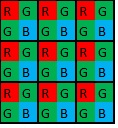

Without loss of generality, we suppose this Bayer configuration for the rest of this exercise.

# Linearization

Black level is an analog offset applied on the output of the photo diode. It allows to keep a normal distribution for the readout noise. For now, we will remove this offset to obtain a linear image, i.e. an image where gray levels are proportional to light intensity in each channel.

In the general case, the black level can be different for each channel. But for the Sony A7S3, as we have just observed, the value is the same for all channels.

Also, we find it convenient to normalize the pixel values such that 1.0 corresponds to pure white.

In [ ]:
bl = blc[0]  # same for all channels
img_lin = (img_raw - bl) / (wl - bl)
print(f"Min and max values after linearization: {img_lin.min()}, {img_lin.max()}")

Observe that we have negative values. We will come back on those when discussing noise. For now we just get rid of them.

In [ ]:
img_lin[img_lin < 0] = 0
print(f"Min and max values after linearization and clamp: {img_lin.min()}, {img_lin.max()}")

# Exposure

In this section we will adjust the target exposure with a global gain on the raw image.

As we have explained in the first lecture, exposure is adjusted right in the sensor, via shutter and ISO speed, even before the image is captured. In order to keep headroom for color and highlight manipulation many cameras intentionally underexpose the images. The Sony A7S3 that we use for this exercise underexposes by approximately 2 "stops", i.e. by a factor of 4. We start by applying this coefficient.

In [ ]:
img_expo = (4 * img_lin).clip(0, 1)

# Demosaicing

In this section we will apply demosaicing to the image.



## Assign Colors to Pixels

To get started, we assign the observed pixel values to their corresponding channels, based on their position.

In [ ]:
def isp_split_colors(img_in) -> np.ndarray:
  h, w = img_in.shape
  img_out = np.zeros((h, w, 3))
  # Red
  img_out[0::2, 0::2, 0] = img_in[0::2, 0::2]
  # Green
  img_out[1::2, 0::2, 1] = img_in[1::2, 0::2]
  img_out[0::2, 1::2, 1] = img_in[0::2, 1::2]
  # Blue
  img_out[1::2, 1::2, 2] = img_in[1::2, 1::2]
  return img_out

img_split = isp_split_colors(img_expo)
imshow(img_split[1842:1872, 1778:1820])

## Bilinear Interpolation

Next we apply naive bilinear interpolation as best guess for all the missing pixels. To interpolate missing G values on red and blue pixels, we use the four closest neighbors. To interpolate missing R and B values on green pixels, we use the two closest vertical or horizontal neighbors.

In [ ]:
def isp_bilinear_demosaicing(img_in) -> np.ndarray:
  kernel_G  = np.array([[0, 0.25, 0], [0.25, 1, 0.25], [0, 0.25, 0]])
  kernel_RB = np.array([[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]])
  img_out = np.empty_like(img_in)
  img_out[:, :, 0] = scipy.ndimage.correlate(img_in[:, :, 0], kernel_RB, mode='mirror')
  img_out[:, :, 1] = scipy.ndimage.correlate(img_in[:, :, 1], kernel_G , mode='mirror')
  img_out[:, :, 2] = scipy.ndimage.correlate(img_in[:, :, 2], kernel_RB, mode='mirror')
  return img_out

img_dem_bil = isp_bilinear_demosaicing(img_split)
imshow(img_dem_bil[1842:1872, 1778:1820])
imshow(img_dem_bil[1502:1532, 1878:1920])

### <font color='blue'> Question 0
Explain how the above code works?


The code implements bilinear demosaicing for a single-channel image with a Bayer filter pattern, converting it into a full-color image. It uses predefined interpolation kernels for the red/blue (R/B) and green (G) channels. The code convolves these kernels with the input image using the scipy.ndimage.correlate function, applying mirror boundary conditions to avoid edge artifacts. The result is stored in an output array img_out.

## Advanced Demosaicing

Finally we attempt to design a more sophisticated demosaicing algorithm.

Remember that we're basically just guessing the values we did not observe. The question is, what values are plausible? Writing a demosaicing algorithm means formulating a strategy for finding plausible values, exploiting supposed properties of the photographed scene.

Our above linear interpolation strategy supposes that the photographed scene does not contain any "sudden" spatial variations. This heuristic is correct for the vast majority of pixels, but wrong for pixels on sharp edges (observe the "zipper" artifact).

To better restore edges and high frequencies, we introduce two heuristics:
- The scene is entirely composed of horizontal and vertical edges. Rather than using all four nearest neighbors for interpolating missing green pixels, we only use the two that follow the direction of the edge.
- Spatial variations at the pixel level are identical in all color channels. High frequencies that we observe in the green channel (where the Bayer pattern has twice more pixels) can be transposed in the red and blue channels.

Based on these heuristics, we propose the following algorithm:
- On each missing green pixel, compute horizontal and vertical linear interplation.
- Among the two interpolations, select the one that leads to minimum variation in its direction. This step yields a fully interpolated G channel.
- On each pixel where R or B were observed, compute respectively ΔR = R–G and ∆B = B–G.
- Compute ∆R and ∆B for pixels where red and blue have not been observed, using linear interpolation.
- Obtain fully interpolated R and B channels by adding the fully interpolated ∆R and ∆B to the fully interpolated G.

In [ ]:
def isp_advanced_demosaicing(img_in) -> np.ndarray:
  img_out = np.empty_like(img_in)
  h, w, _ = img_in.shape
  # Compute two proposals for G
  kernel_dir = np.array([0.5, 1.0, 0.5])
  green_H = scipy.ndimage.correlate1d(img_in[:, :, 1], kernel_dir, axis=1, mode='mirror')
  green_V = scipy.ndimage.correlate1d(img_in[:, :, 1], kernel_dir, axis=0, mode='mirror')
  # Compute variation and select best proposal for G
  kernel_var  = np.array([-1, 0, 1])
  var_H = np.abs(scipy.ndimage.correlate1d(green_H, kernel_var, axis=1, mode='mirror'))
  var_V = np.abs(scipy.ndimage.correlate1d(green_V, kernel_var, axis=0, mode='mirror'))
  img_out[:, :, 1] = (var_H > var_V).choose(green_H, green_V)
  # Compute deltaR and deltaB
  deltaR = np.zeros((h, w))
  deltaR[0::2, 0::2] = img_in[0::2, 0::2, 0] - img_out[0::2, 0::2, 1]
  deltaB = np.zeros((h, w))
  deltaB[1::2, 1::2] = img_in[1::2, 1::2, 2] - img_out[1::2, 1::2, 1]
  # Linear interpolation for deltaR and deltaB
  kernel_RB = np.array([[0.25, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 0.25]])
  deltaR = scipy.ndimage.correlate(deltaR, kernel_RB, mode='mirror')
  deltaB = scipy.ndimage.correlate(deltaB, kernel_RB, mode='mirror')
  # Compute R and B
  img_out[:, :, 0] = (img_out[:, :, 1] + deltaR).clip(0, 1)
  img_out[:, :, 2] = (img_out[:, :, 1] + deltaB).clip(0, 1)

  return img_out

img_dem_adv = isp_advanced_demosaicing(img_split)
imshow(img_dem_adv[1842:1872, 1778:1820])
imshow(img_dem_adv[1502:1532, 1878:1920])

# White Balance

In this section we will correct the white balance and try the most simple automatic white balance algorithm.

Color consistency, also called chromatic adaptation, is the brain's ability to neutralize the spectrum of the ambient light.

White balance, which mimicks this physiological aspect, consists in applying gains on Blue and Red channels to neutralize objects that reflect all the spectrum without absorption, also known as objects of gray color.

Automatic White Balance (AWB) is the name of the algorithm which tries to guess this blue and red gains.

## As-Shot White Balance

White balance gains resulting from camera AWB algorithm are part of the metadata.

In [ ]:
# Let's extract the white balance gain from the metadata. We name it White Balance As Shot.
wb_as_shot = np.array(raw.camera_whitebalance)[:3]
print(f"White balance gain from camera AWB: {wb_as_shot}")

In [ ]:
# Show the image before and after the white balance.
imshow(img_dem_adv[900:1650, 2300:3050])
img_wb_as_shot = img_dem_adv * wb_as_shot
imshow(img_wb_as_shot[900:1650, 2300:3050])

## Auto White Balance

Methods that estimate the white balance gain are called auto white balance algorithms, and can be very sophisticated (semantic interpretation of the scene via AI, use of additionnal sensors to observe the spectrum of the ambient light, etc...)

A naive classic but surprisingly effective such algorithm is called gray-world white balancing and relies on the gray world assumption, which states that the scene, on average, is gray. The gray-world assumption holds if we have a good distribution of colors in the scene. Assuming that the scene, on average, is gray, the reflected color, on average, is the color of the light source. Therefore, we can estimate the illumination color cast by looking at the average color and comparing it to gray.

## <font color='blue'> Exercise 1

Estimate the white balance gains using the gray-world assumption.

In [ ]:
########################
# use the img_dem_adv image and write white balance gain into wb_auto

average_color = np.mean(img_dem_adv, axis=(0, 1))

wb_auto = 255 / average_color

#########################
print(f"White balance gain using the gray-world assumption: {wb_auto}")

In [ ]:
img_wb_auto = img_dem_adv * wb_auto
imshow(img_wb_auto[900:1650, 2300:3050])

As you can see, the results are rather close. Nevertheless the camera's more sophisticated auto white balance is superior: it correctly neutralizes the white background of the stripe patterns, while it remains a bit blueish using the gray-world assumption.

# Color Rendering

In this section we will play on the color rendering by applying a color matrix and adjust the saturation of colors.

## Color Matrix

A color matrix is a 3×3 matrix applied to the vector of (R, G, B).

\begin{matrix}
\begin{bmatrix}
    R_{out} \\
    G_{out} \\
    B_{out}
\end{bmatrix} =
\begin{bmatrix}
    m_{11} & m_{12} & m_{13} \\
    m_{21} & m_{22} & m_{23} \\
    m_{31} & m_{32} & m_{33}
\end{bmatrix}
\begin{bmatrix}
    R_{in} \\
    G_{in} \\
    B_{in}
\end{bmatrix}
\end{matrix}

The goal of the matrix is to modulate the color rendering. This is a very simple way of altering the colors.
More sophisiticated ones are used in modern cameras.

Color Matrix can be used to reach fidelity, or saturate more the colors, or give a particular signature to the colors.

All the difficulty resides in finding the good matrix.

Color Matrix resulting from camera color tuning is part of the metadata.

In [ ]:
color_matrix = raw.color_matrix[0:3,0:3]
print(f"Color matrix: {color_matrix}")

While the matrix has 9 coefficients, by convention it must change neither exposure nor white balance. In other words, gray pixels (where R=G=B) must remain unchanged. This means that the sum of each row must be equal to one. Thus, the matrix has actually only 6 degrees fo freedom.

Let's verify this property:

In [ ]:
print(f"Color matrix row sum: {color_matrix.sum(axis=1)}")

Now let's apply the matrix to the image and look at the result.

In [ ]:
def isp_apply_matrix(img_in, color_matrix) -> np.ndarray:
  return np.dot(img_in, color_matrix.T).clip(0, 1)

img_cm = isp_apply_matrix(img_wb_as_shot, color_matrix)
imshow(img_cm[900:1650, 2300:3050])

Observe that the colors are more vivid, more saturated than before.

# Color Artifacts

After applying white balance and color matrix, we observe that something is wrong. Look at all these reddish color artifacts on the high frequency stripe patterns.

### <font color='blue'> Exercise 2

What is wrong in our processing pipeline? Hint: it's related to one of the assumtions in our demosaicing algorithm.

Propose a fix and implement it.

The issue is related to the assumption that spatial variations at the pixel level are identical in all color channels. This assumption may not hold in all situations, and it can lead to artifacts.

To resolve the issue, we can use the Malvar Demosaicing algorithm which separates the interpolation of the green channel from the red and blue channels, handling channel-specific variations better.

In [ ]:
def malvar_demosaicing(img_in) -> np.ndarray:
    img_out = np.empty_like(img_in)
    h, w, _ = img_in.shape

    green_kernel = np.array([[0, 1, 0],
                             [1, 4, 1],
                             [0, 1, 0]]) / 4.0
    img_out[:, :, 1] = scipy.ndimage.correlate(img_in[:, :, 1], green_kernel, mode='reflect')

    red_kernel = np.array([[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]]) / 4.0
    blue_kernel = red_kernel

    img_out[:, :, 0] = scipy.ndimage.correlate(img_in[:, :, 0], red_kernel, mode='reflect')
    img_out[:, :, 2] = scipy.ndimage.correlate(img_in[:, :, 2], blue_kernel, mode='reflect')

    return img_out.clip(0, 1)

img_cm = isp_apply_matrix(isp_advanced_demosaicing(img_split)* wb_as_shot, color_matrix)
imshow(img_cm[900:1650, 2300:3050])
img_cm = isp_apply_matrix(isp_advanced_demosaicing(img_split * wb_as_shot), color_matrix)
imshow(img_cm[900:1650, 2300:3050])

img_cm = isp_apply_matrix(malvar_demosaicing(img_split)* wb_as_shot, color_matrix)
imshow(img_cm[900:1650, 2300:3050])
img_cm = isp_apply_matrix(malvar_demosaicing(img_split * wb_as_shot), color_matrix)
imshow(img_cm[900:1650, 2300:3050])

# Gamma Compression

Until now our image is still linear, i.e. the graylevels are proportional to the amount of light received by the sensor. However, this is not what screens and operating systems expect. They expect the image to be non-linear, with a so-called gamma compression applied.

In order to faithfully reproduce the brightness and contrast of the scene on screen, we must apply such a gamma compression.

In [ ]:
def isp_apply_gamma(img_in) -> np.ndarray:
  return img_in ** (1/2.2)

img_gamma = isp_apply_gamma(img_cm)

imshow(img_cm)
imshow(img_gamma)

# Common Image Enhancements

The above image has received all essential processing steps. But probably it will not receive a lot of likes when posted on social networks, because it does not "pop". Let's apply some basic image enhancements to make the image more exciting.

## Color Saturation

We would like to play with the saturation of colors.

Let's first understand what would be an image without colors: this would be an image with the same color on each channel.

This corresponds to a matrix of the following form:

\begin{matrix}
\begin{bmatrix}
    R_{out} \\
    G_{out} \\
    B_{out}
\end{bmatrix} =
\begin{bmatrix}
    m_{r2gray} & m_{g2gray} & m_{b2gray} \\
    m_{r2gray} & m_{g2gray} & m_{b2gray} \\
    m_{r2gray} & m_{g2gray} & m_{b2gray}
\end{bmatrix}
\begin{bmatrix}
    R_{in} \\
    G_{in} \\
    B_{in}
\end{bmatrix}
\end{matrix}

We want the lightness of the resulting image to be identical to the original image.
A simple way to achieve this is to have the sum of the coefficients of each line to be equal to one.
Setting each coefficient to $1/3$ is simple but doesn’t work as well as expected. The reason is that human vision is most sensitive to green light, less sensitive to red light, and the least sensitive to blue light. Therefore, the three colors should have different weights in the distribution.

The following weights comes from the analog television standards and are commonly used to convert RGB values to Y (or Luma) gray levels:

$Y = 0.299R + 0.587G + 0.114B$

In [ ]:
# Convert the image to Gray
gray_matrix = np.array([
  [0.299, 0.587, 0.114],
  [0.299, 0.587, 0.114],
  [0.299, 0.587, 0.114]
])

img_gray = isp_apply_matrix(img_gamma, gray_matrix)

imshow(img_gray)

An intuitive but effective way to play with the saturation of colors is to interpolate/extrapolate between the colorToGray matrix and the Identity Matrix.

### <font color='blue'> Exercise 3

Write a function that generates a saturation adjustment matrix according to a parameter.

In [ ]:
def make_sat_matrix(sat_param) -> np.ndarray:
    color_to_gray = np.array([0.299, 0.587, 0.114])

    identity_matrix = np.identity(3)

    sat_matrix = (1 - sat_param) * color_to_gray + sat_param * identity_matrix

    return sat_matrix


sat_matrix = make_sat_matrix(1.5)

img_sat = isp_apply_matrix(img_gamma, sat_matrix)

imshow(img_sat)

## Global Contrast

The global contrast in the image, i.e. the respective levels of shadows and highlights, can be adjusted via a transfer function. An S-curve is a simple way to adjust the contrast.

It is usually implemented with a Look-Up Table.

In [ ]:
def isp_apply_LUT(img_in, LUT) -> np.ndarray:
  N = len(LUT)
  return LUT[(img_in * N).astype(int).clip(0, N-1)]

Let's code a simple S-curve LUT with a sinus.

In [ ]:
N = 1024
t = np.linspace(0, 1 - 1/N, N)
LUT_sine = (np.sin(t * np.pi - np.pi / 2) + 1) / 2

plt.plot(LUT_sine)
plt.show()

In [ ]:
img_contrast = isp_apply_LUT(img_sat, LUT_sine)

imshow(img_contrast)

You can observe that the increase in contrast has further increased the color saturation.

## Unsharp Mask

In this section we will see a classical method to improve the perceptual sharpness of the image.


In photography, acutance describes a subjective perception of sharpness that is related to the edge contrasts in an image. Lenses act naturally as low pass filters and smooth the fine details, or high spatial frequencies, in an image.

Various techniques can be used to increase the acutance, or make the image look sharper.

Unsharp masking (USM) is an image sharpening technique, first implemented in darkroom photography, but now commonly used in digital image processing software. Its name derives from the fact that the technique uses a blurred, or "unsharp", negative image to create a mask of the original image.

$sharpened = original + (original − blurred) × amount$

In [ ]:
def isp_blur(img_in, sigma):
  return scipy.ndimage.gaussian_filter(img_in, [sigma, sigma, 0], mode="nearest")

img_blur = isp_blur(img_contrast, sigma=3)

imshow(img_contrast[900:1650, 2300:3050])
imshow(img_blur[900:1650, 2300:3050])

### <font color='blue'> Exercise 4

Write a function that applies an unsharp mask with a strength parameter as input.

In [ ]:
def isp_usm(img_in, sigma, strength) -> np.ndarray:
    img_blurred = scipy.ndimage.gaussian_filter(img_in, sigma)

    img_mask = img_in - img_blurred

    img_sharp = img_in + strength * img_mask

    img_sharp = np.clip(img_sharp, 0, 255)

    return img_sharp

img_sharp = isp_usm(img_contrast, sigma=3, strength=0.5)

imshow(img_sharp[900:1650, 2300:3050])

Now our image is ready to receive some oohs and aahs!

# Philosophical End Note

At the beginning of this course we introduced two assumptions about the world and stated that they are true in most cases:
- The image contains no sudden spatial variations (thus we can use bilinear interpolation for demosaicing).
- The world is gray (thus we can use the average of each channel to compute the white balance scales).

Then, in order to make the image more "interesting" for the human eye:
- We emphasized sudden spatial variations (sharpening).
- We made the image less gray (more colorful via saturation, more distinct black or white via contrast).

Are these two in contradiction? Not at all. According to Claude Shannon's information theory, "the less probable an event is, the more surprising it is and the more information it yields." From an evolutionary point of view it makes totally sense that our visual system pays more attention to images that violate assumptions that are commonly true.



